<a href="https://colab.research.google.com/github/Lenflammeur/UCL-MSc_Project/blob/main/TCN_TimeSeries_Approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load Library

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from tqdm.notebook import tqdm
import tensorflow as tf

from tcn import TCN

To monitor training progress and compare evaluation metrics for different models, I use the function below to plot metrics captured from the training job such as training and validation loss or accuracy.

In [2]:
def plot_curves(train_data, val_data, label='Accuracy'):
    """Plot training and validation metrics on single axis.

    Args:
        train_data: list, metrics obtrained from training data.
        val_data: list, metrics obtained from validation data.
        label: str, title and label for plot.
    Returns:
        Matplotlib plot.
    """
    plt.plot(np.arange(len(train_data)) + 0.5,
             train_data,
             "b.-", label="Training " + label)
    plt.plot(np.arange(len(val_data)) + 1,
             val_data, "r.-",
             label="Validation " + label)
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel(label)
    plt.grid(True)  

### Read the dataset


In [3]:
df = pd.read_csv('all_stocks_5yr.csv', delimiter=',')

## APPLE Stock

In [4]:
df_AAPL = df.query("Name == 'AAPL'")
df_AAPL.shape

(1259, 7)

### Display top5 Record

In [5]:
df_AAPL.head()

,date,open,high,low,close,volume,Name
1259,2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416,AAPL
1260,2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425,AAPL
1261,2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363,AAPL
1262,2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995,AAPL
1263,2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154,AAPL


In [6]:
pd.options.plotting.backend = "plotly"
df_AAPL.plot(x='date', y='close')

### Split the data

I am going to use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [7]:
column_indices = {name: i for i, name in enumerate(df_AAPL.columns)}

n = len(df_AAPL)
train_df = df_AAPL[0:int(n*0.7)]
val_df = df_AAPL[int(n*0.7):int(n*0.9)]
test_df = df_AAPL[int(n*0.9):]

num_features = df.shape[1]

In [8]:
close_aapl_train = train_df['close'].values
close_aapl_val = val_df['close'].values
close_aapl_test = test_df['close'].values
print("Shapes:")
print("train", close_aapl_train.shape)
print("val", close_aapl_val.shape)
print("test",close_aapl_test.shape)

Shapes:
train (881,)
val (252,)
test (126,)


### Lookback 12 days windows

In [9]:
lookback_window = 12 

In [10]:
# split a univariate sequence into samples
def split_sequence(sequence, window_size):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + window_size
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


A model that makes a prediction one day into the future, given six days of history, would need a window like this:

  ![One prediction one hour into the future.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/raw_window_1h.png?raw=1)

### Split

Given a list of consecutive inputs, the `split_sequence` function will convert them to a window of inputs and a window of labels.

For example with a window of size 6, it will be split like this:

![The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/split_window.png?raw=1)


In [11]:
X_train, y_train = split_sequence(close_aapl_train, lookback_window)
X_val, y_val = split_sequence(close_aapl_val, lookback_window)
X_test, y_test = split_sequence(close_aapl_test, lookback_window)

In [12]:
print(X_train.shape)
print(y_train.shape)

(869, 12)
(869,)


## Different possible type of models:

### Linear model

The simplest **trainable** model is a linear transformation between the input and output. In this case the output from a time step only depends on that step:

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/narrow_window.png?raw=1)

A `tf.keras.layers.Dense` layer with no `activation` set is a linear model. The layer only transforms the last axis of the data from `(batch, time, inputs)` to `(batch, time, units)`; it is applied independently to every item across the `batch` and `time` axes.

The linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecutive time steps. The `time` axis acts like another `batch` axis. There are no interactions between the predictions at each time step.

![A single step prediction](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_window.png?raw=1)

### Multi-step dense

A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:


![Three time steps are used for each prediction.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/conv_window.png?raw=1)


## Deep Learning part

In [13]:
MAX_EPOCHS = 100

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

The difference between this `conv_model` and the `multi_step_dense` model is that the `conv_model` can be run on inputs of any length. The convolutional layer is applied to a sliding window of inputs:

![Executing a convolutional model on a sequence](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/structured_data/images/wide_conv_window.png?raw=1)

In this case we will use it with a dense layer to have an output of size 1

### TCN Model

In [14]:
i = Input(shape=(lookback_window, 1))
m = TCN()(i)
m = Dense(1, activation='linear')(m)
model = Model(inputs=[i], outputs=[m])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 1)]           0         
_________________________________________________________________
tcn (TCN)                    (None, 64)                136256    
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 136,321
Trainable params: 136,321
Non-trainable params: 0
_________________________________________________________________


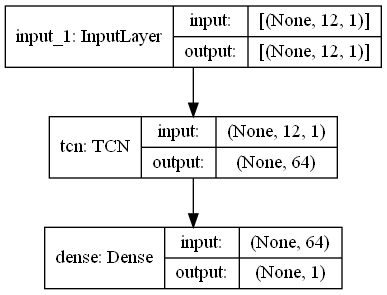

In [15]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

### Time for Model training...

In [17]:
print('Train...')
history = model.fit(X_train,
                    y_train, 
                    epochs=100,
                    validation_data=(X_val, y_val))

Train...
Epoch 1/100
28/28 [==============================] - 4s 51ms/step - loss: 99943.3504 - mean_absolute_error: 233.1813 - val_loss: 3070.1018 - val_mean_absolute_error: 54.7449
Epoch 2/100
28/28 [==============================] - 1s 24ms/step - loss: 689.2497 - mean_absolute_error: 21.9802 - val_loss: 218.1282 - val_mean_absolute_error: 14.0321
Epoch 3/100
28/28 [==============================] - 1s 23ms/step - loss: 66.5859 - mean_absolute_error: 6.6992 - val_loss: 21.3655 - val_mean_absolute_error: 3.2851
Epoch 4/100
28/28 [==============================] - 1s 21ms/step - loss: 37.5036 - mean_absolute_error: 4.5709 - val_loss: 22.2502 - val_mean_absolute_error: 3.2907
Epoch 5/100
28/28 [==============================] - 1s 22ms/step - loss: 23.7757 - mean_absolute_error: 3.6423 - val_loss: 91.0829 - val_mean_absolute_error: 8.6492
Epoch 6/100
28/28 [==============================] - 1s 22ms/step - loss: 39.7104 - mean_absolute_error: 4.8640 - val_loss: 17.8492 - val_mean_absolu

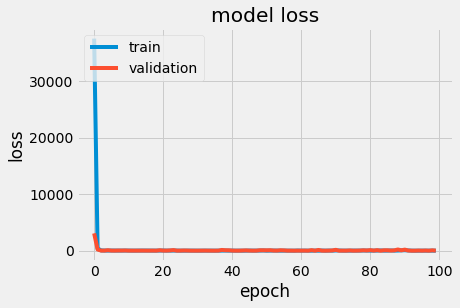

In [50]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Prediction with TCN Model

In [18]:
predict = model.predict(X_test)

### Plot the Result

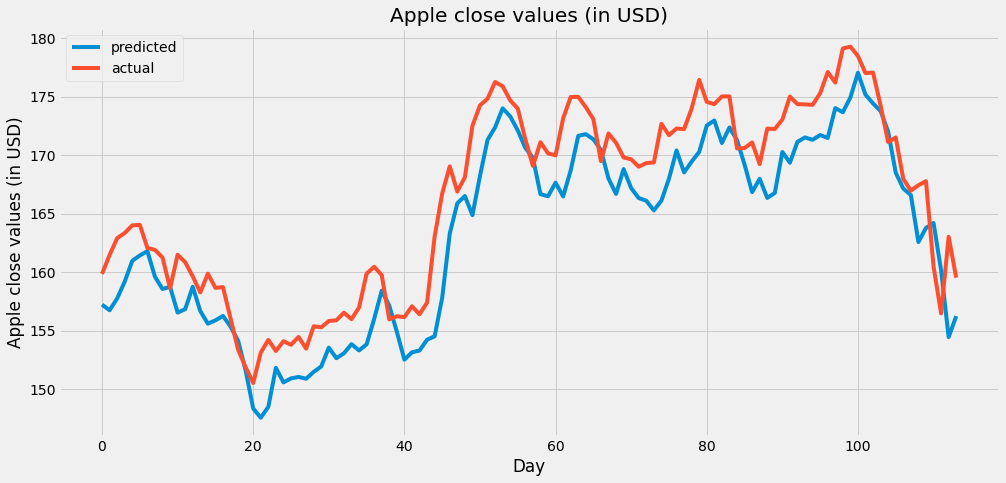

In [29]:
plt.style.use("fivethirtyeight")
plt.figure(figsize = (15,7))
plt.plot(predict)
plt.plot(y_test)
plt.title('Apple close values (in USD)')
plt.legend(['predicted', 'actual'])
plt.xlabel("Day")
plt.ylabel("Apple close values (in USD)")
plt.show()

### Inversing the model

In [20]:
from tensorflow.keras.layers import UpSampling1D
from tensorflow import keras

In [21]:
y_train_inverse = y_train.reshape((y_train.shape[0], 1))
y_val_inverse = y_val.reshape((y_val.shape[0], 1))
y_test_inverse = y_test.reshape((y_test.shape[0], 1))
y_test_inverse.shape

(114, 1)

In [22]:
model_inverse = keras.models.Sequential()
model_inverse.add(keras.layers.InputLayer(input_shape=[1, 1]))
model_inverse.add(keras.layers.UpSampling1D(12))
model_inverse.add(TCN())
model_inverse.add(keras.layers.Dense(12, activation='linear'))
model_inverse.add(keras.layers.Reshape((12, 1), input_shape=(12, )))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling1d (UpSampling1D) (None, 64, 1)             0         
_________________________________________________________________
tcn_1 (TCN)                  (None, 64)                136256    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
_________________________________________________________________
reshape (Reshape)            (None, 12, 1)             0         
Total params: 137,036
Trainable params: 137,036
Non-trainable params: 0
_________________________________________________________________


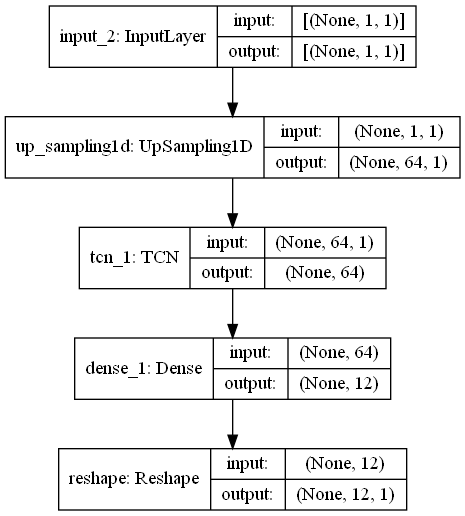

In [23]:
model_inverse.summary()
tf.keras.utils.plot_model(model_inverse, show_shapes=True)

In [24]:
model_inverse.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

In [25]:
y_train_inverse_reshaped = y_train_inverse.reshape((y_train.shape[0], 1, 1))
y_val_inverse_reshaped = y_val_inverse.reshape((y_val.shape[0], 1, 1))
y_test_inverse_reshaped = y_test_inverse.reshape((y_test.shape[0], 1, 1))

In [26]:
print('Train...')
history_inverse = model_inverse.fit(y_train_inverse_reshaped, 
                                    X_train, 
                                    epochs=100,
                                    validation_data=(y_val_inverse_reshaped, X_val))

Train...
Epoch 1/100
28/28 [==============================] - 5s 81ms/step - loss: 509560.8222 - mean_absolute_error: 381.9167 - val_loss: 979.4104 - val_mean_absolute_error: 28.0721
Epoch 2/100
28/28 [==============================] - 2s 66ms/step - loss: 356.3578 - mean_absolute_error: 14.8548 - val_loss: 110.6029 - val_mean_absolute_error: 8.6493
Epoch 3/100
28/28 [==============================] - 2s 62ms/step - loss: 40.0976 - mean_absolute_error: 4.8530 - val_loss: 23.1590 - val_mean_absolute_error: 3.8237
Epoch 4/100
28/28 [==============================] - 2s 59ms/step - loss: 17.5076 - mean_absolute_error: 3.1991 - val_loss: 18.3375 - val_mean_absolute_error: 3.2422
Epoch 5/100
28/28 [==============================] - 2s 59ms/step - loss: 16.8097 - mean_absolute_error: 3.0895 - val_loss: 14.6307 - val_mean_absolute_error: 2.8126
Epoch 6/100
28/28 [==============================] - 2s 58ms/step - loss: 16.6968 - mean_absolute_error: 3.0067 - val_loss: 17.6026 - val_mean_absolut

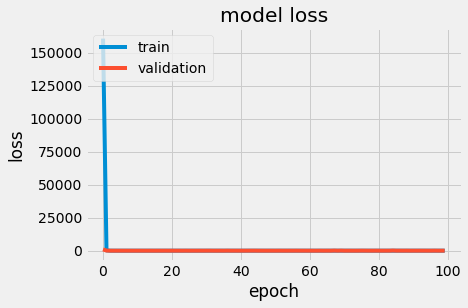

In [51]:
# summarize history for loss
plt.plot(history_inverse.history['loss'])
plt.plot(history_inverse.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [27]:
predict_inverse = model_inverse.predict(y_test_inverse_reshaped)

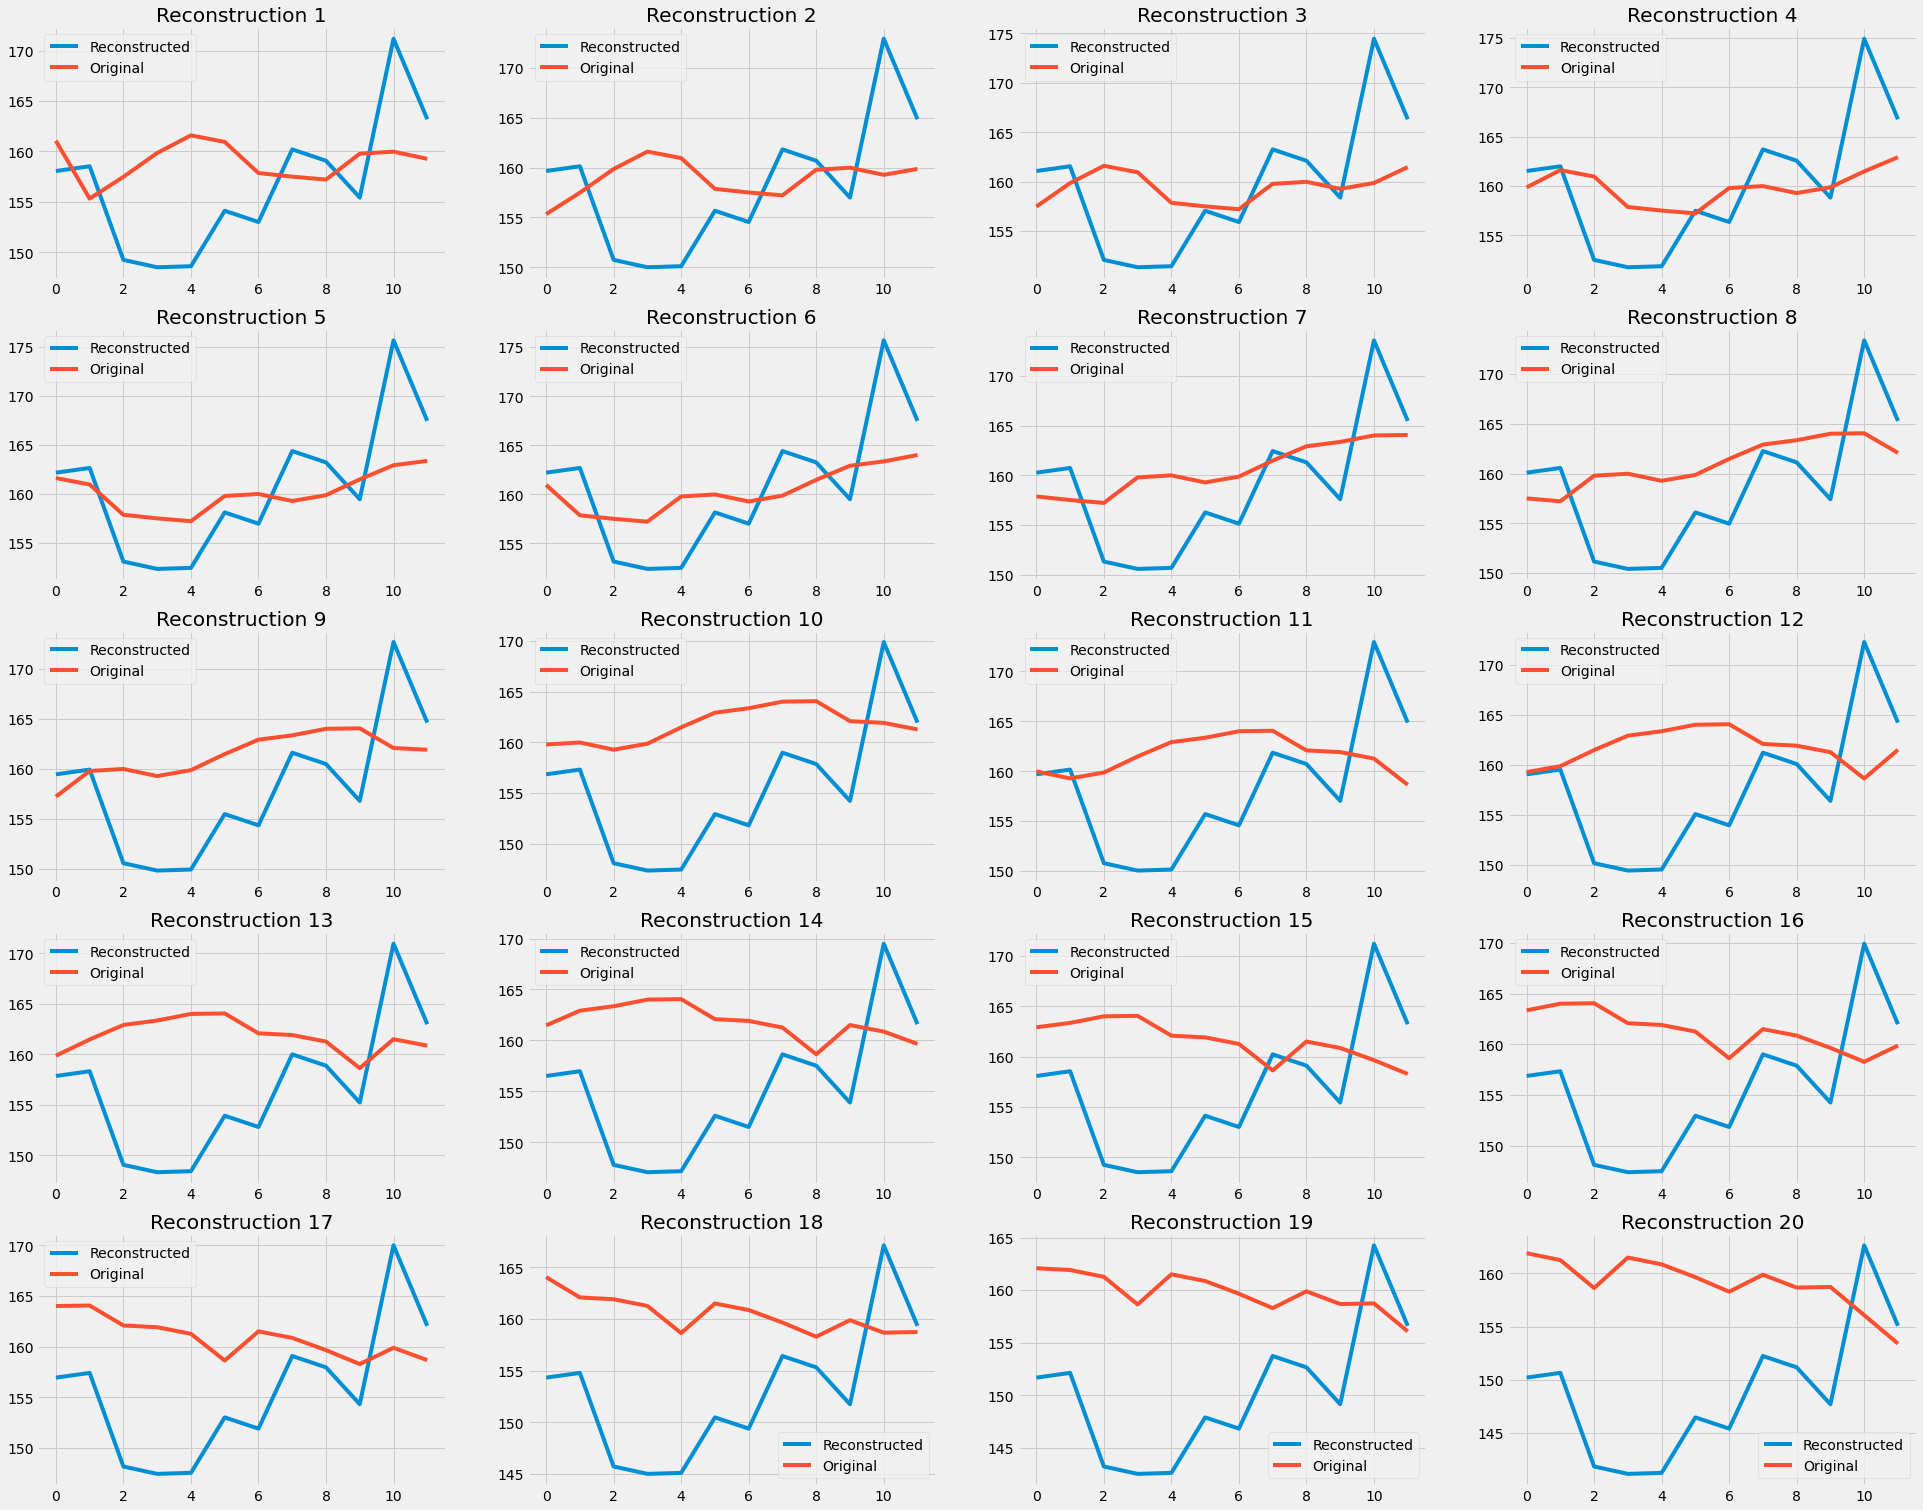

In [48]:
plt.style.use("fivethirtyeight")
axes = plt.subplots(5, 4, figsize = (30, 25))[1]
for i, ax in enumerate(axes.flatten()):
    ax.plot(predict_inverse[(9*i)%114])
    ax.plot(X_test[(9*i)%114])
    ax.set_title('Reconstruction {}'.format(i+1))
    ax.legend(['Reconstructed', 'Original'])
plt.show()